# Hit calling
`scmorph` leverages single-cell morpholigical profiles for hit calling. This has
the advantage that it does not rely on averaging or summarizing a potentially
diverse cell population. Instead it proceeds in these steps
1. Create PCA of single-cell profiles
2. Per treatment and plate (where applicable), calculate how far treated cells
   are from control cells.
3. Calculate the KS statistic and test for each treatment whether its KS is
   higher than that of a background distribution. This background distribution
   is created by testing all untreated wells against each other.

In this way, `scmorph` derives a hit score that is based entirely on single-cell
populations.

Let's see this in practice!

In [1]:
import numpy as np
import pandas as pd
import scmorph as sm
import seaborn as sns
import matplotlib.pyplot as plt


# Convenience function for loading in example data
def load_example_data():
    """# Load in a subset of the Rohban data"""
    # To load in the full dataset, you may use sm.datasets.rohban2017()
    # but note that this will download the dataset from the internet,
    # occupying ~8Gb of disk space.
    adata = sm.datasets.rohban2017_minimal()

    # Fill in information about untreated cells. For more information, check out the
    # batch effect correction tutorial.
    adata.obs["TARGETGENE"] = adata.obs["TARGETGENE"].astype(str).replace("nan", "UNTREATED")

    # Ensure plate names are strings
    adata.obs["Image_Metadata_Plate"] = adata.obs["Image_Metadata_Plate"].astype(str)

    # Remove cells with missing values
    sm.pp.drop_na(adata)

    # standardize the data per plate
    sm.pp.scale_by_batch(
        adata, batch_key="Image_Metadata_Plate", treatment_key="TARGETGENE", control="UNTREATED"
    )

    # Randomise order of samples in adata to help with plotting
    adata = adata[np.random.permutation(adata.obs.index), :]
    return adata

In [2]:
# Convenience function for plotting the KS statistics
# Skip this on first read, but you can use it as reference for plotting
# the results of the KS test discussed later in this tutorial
def plot_ks_statistics(ref_ks, treat_ks):
    """Plot output of `get_ks`"""
    # Combine reference and treatment KS statistics for plotting
    ref_ks["group"] = "DMSO"
    treat_ks["group"] = "CEPBA"
    combined_ks = pd.concat([ref_ks, treat_ks])

    ### Plotting

    # Create the violin plot
    plt.figure(figsize=(4, 4), dpi=250)
    sns.violinplot(x="group", y="ks_stat", data=combined_ks, inner=None)

    # Overlay with swarm plot
    sns.swarmplot(
        x="group",
        y="ks_stat",
        data=combined_ks,
        hue="is_significant_0.05",
        palette={True: "white", False: "black"},
        edgecolor="black",
        linewidth=1,
        size=6,
    )

    # Add labels and title
    plt.xlabel("")
    plt.ylabel("KS Statistic")
    plt.title("KS Statistic Distribution")
    plt.legend(title="Significant\n(5% FDR)", loc="upper left")
    plt.show()

Note that this tutorial uses only a small dataset, comprising five
plates and only one treatment (CEBPA). If you would like to see this with a
bigger dataset, you can use `sm.datasets.rohban2017()` in the code above, but
note that this will download the dataset from the internet, occupying ~8Gb of
disk space.

Let's see how strongly CEBPA affects single-cell morphological profiles in PCA.
For this, we first normalize the data to the controls on each plate. Then, we
will look at the single-cell PCA to see if there's a visual difference between
the two groups.

In [3]:
# Step 1:
adata = load_example_data()

# Compute PCA
sm.pp.pca(adata)

We can see the separation of CEBPA from DMSO treated cells in PCA as per below.
This is a good indicator the treatment is having a strong effect.

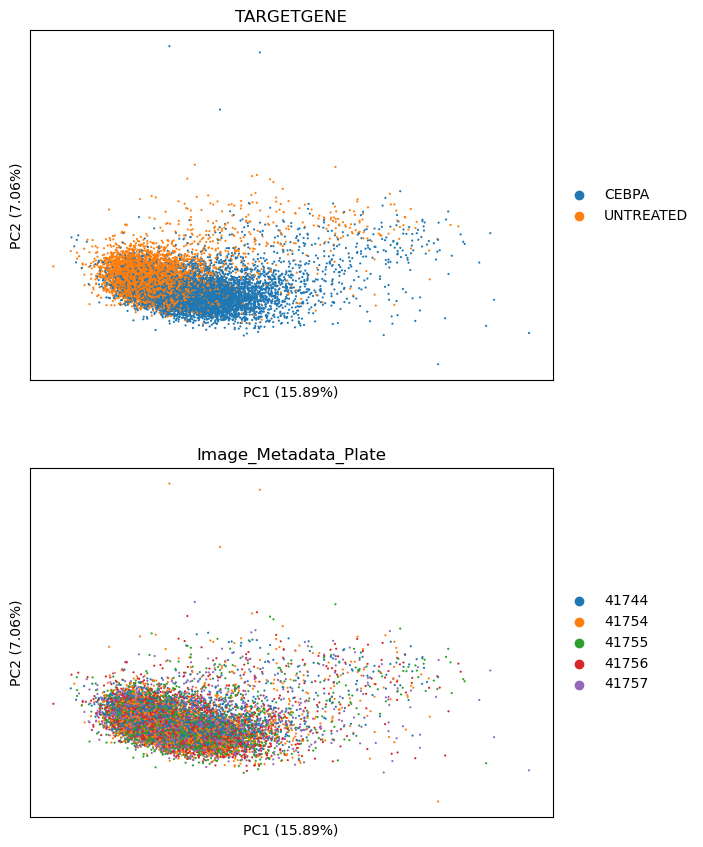

In [4]:
sm.pl.pca(adata, color=["TARGETGENE", "Image_Metadata_Plate"], ncols=1)

`scmorph` also allows you to look at the separation of treatment and control in
PCA with cumulative distributions. For example, the below plots show us that
CEBPA and DMSO treated cells differ in PC1 and 2, but not so much in PC3 and 4.

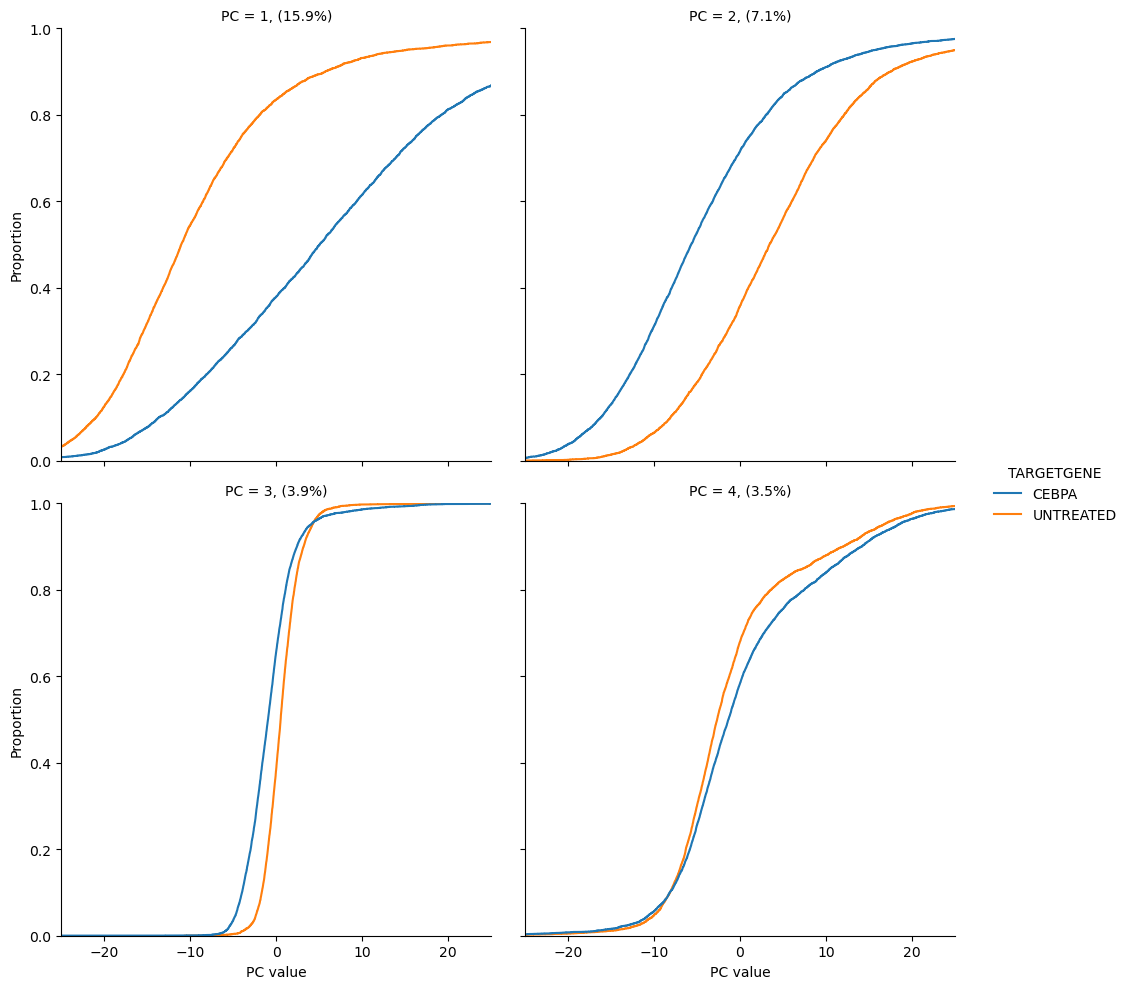

In [5]:
sm.pl.cumulative_density(
    adata, [0, 1, 2, 3], layer="pca", color="TARGETGENE", xlim=(-25, 25), xlabel="PC value", n_col=2
)

Note that we are creating the above PCA for visualisation purposes only. When
performing hit calling with `scmorph`, most of these steps happen automatically.
The only exception is per-plate normalization, which must be applied before. We
can perform hit calling with the `sm.tl.get_ks` function, where we can specify
all relevant metadata and perform hit calling.

This function returns two things: a background dataframe, where control wells
are tested for differences with all the other control wells on the same plate,
and a treatment dataframe, where each treatment has been tested against all
controls on the same plate.

In [6]:
# Step 1, 2 and 3: Per treatment and plate (where applicable), calculate how
# far treated cells are from control cells.
adata = load_example_data()

ref_ks, treat_ks = sm.tl.get_ks(
    adata,
    treatment_key="TARGETGENE",
    control="UNTREATED",
    well_key="Image_Metadata_Well",
    batch_key="Image_Metadata_Plate",
    control_wells=None,
)
treat_ks

,plate,control,treatment,ks_stat,ks_pval,ks_qval,is_significant_0.05,is_significant_0.1
0,41744,UNTREATED,CEBPA,0.480886,7.612527e-119,3.806263e-118,True,True
0,41754,UNTREATED,CEBPA,0.441858,5.484131e-106,9.140219e-106,True,True
0,41755,UNTREATED,CEBPA,0.354889,6.734590e-71,8.418237e-71,True,True
0,41756,UNTREATED,CEBPA,0.441083,2.915800e-112,7.289501e-112,True,True
0,41757,UNTREATED,CEBPA,0.294381,1.015384e-41,1.015384e-41,True,True


CEBPA tested as significantly different from control on each of the five plates,
as indicated by the `is_significant_0.05` column, which indicates that the
treatment was significant at the 5% FDR threshold. To see this visually, we can
combine the results in a plot like below.

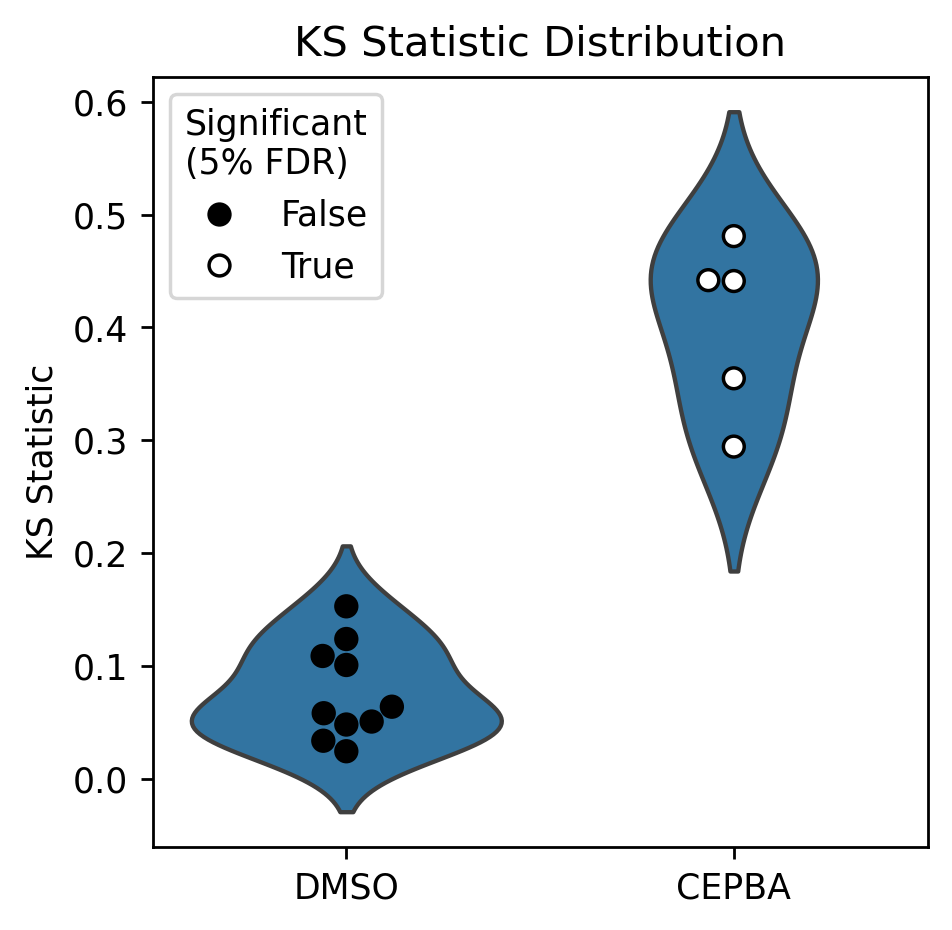

In [7]:
plot_ks_statistics(ref_ks, treat_ks)

Note that in the above plot, each point in the DMSO violin indicates a
one-to-many comparison (one DMSO well vs. all the other DMSO wells on the same
plate), whereas the CEBPA points indicate a many-vs-many comparison (all CEBPA
wells on a plate vs all DMSO wells on that plate).

We can redo this analysis to have the groups on equal footing: by testing both
wells of CEBPA separately against all DMSO wells, for example. Note that this is
similar to the the above, and only differs in how samples are pooled.

In [8]:
# Assign treatment and control groups, with CEBPA replicates as separate groups
adata = load_example_data()
adata.obs["group"] = "control"
adata.obs.loc[adata.obs["Image_Metadata_Well"] == "f02", "group"] = "CEBPA_rep1"
adata.obs.loc[adata.obs["Image_Metadata_Well"] == "f04", "group"] = "CEBPA_rep2"

/var/folders/y1/ypchvhzj1w3b4g92l5rhrnwh0000gq/T/ipykernel_24448/178219972.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["group"] = "control"


In [9]:
# Repeat above analysis with separate groups for CEBPA replicates
ref_ks, treat_ks = sm.tl.get_ks(
    adata,
    treatment_key="group",
    control="control",
    well_key="Image_Metadata_Well",
    batch_key="Image_Metadata_Plate",
    control_wells=None,
)

Having separated technical replicates, we can see that each of the CEBPA wells
tests significantly different to control. In the below, each CEBPA point
indicates one technical replicate of CEBPA.

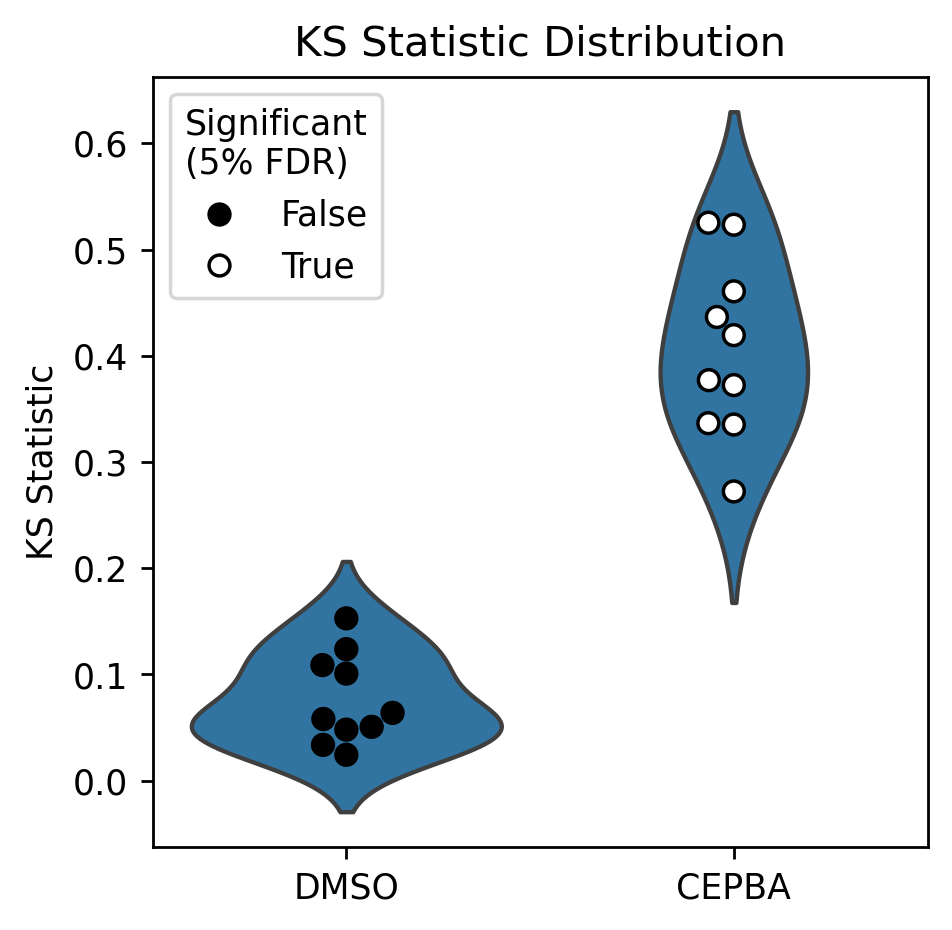

In [10]:
plot_ks_statistics(ref_ks, treat_ks)

In this tutorial, we covered how to perform hit calling with `scmorph` and
interpret the results of the KS test. If you want to further interpret the
outputs, consider ranking treatments by how often they were considered
significant across replicates, for example.